## Main

In [ ]:
import os 
from IPython.display import clear_output

if not os.path.exists('/content/clip-video-embedder'):
    !git clone -b dev https://github.com/abreza/clip-video-embedder.git
    %cd /content/clip-video-embedder
    !pip install -r requirements.txt
    clear_output()

%cd /content/clip-video-embedder

from utils.video_loader import download_video_from_youtube
from dataloaders.rawvideo_util import RawVideoExtractor

/content/clip-video-embedder


In [ ]:
def downlaod_video(video_id):
  number_of_failure = 0
  while True:
    try:
        video_path = download_video_from_youtube(video_id[2:], f'./videos/')
        print(f'Number of Failure: {number_of_failure}')
        return video_path
    except Exception as e:
        number_of_failure += 1
        clear_output()
        continue

In [ ]:
path = downlaod_video('https://www.youtube.com/watch?v=3UbQ0UDmbbw')

Download complete.
Number of Failure: 8


In [ ]:
import dataloaders.rawvideo_util as df

import importlib
importlib.reload(df)

from dataloaders.rawvideo_util import RawVideoExtractor

In [ ]:
import json
import matplotlib.pyplot as plt
import time
import numpy as np
import math
import cv2
import random
import torch
from torch.nn.utils.rnn import pad_sequence


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

clear_output()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = 'CLIP'

if model_name == 'CLIP':
  from transformers import CLIPProcessor, CLIPModel
  model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device).eval()
  processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

  
  # ! pip install git+https://github.com/openai/CLIP.git 

  # import clip
  # model, preprocess = clip.load("ViT-B/32")
  # model = model.to(device).eval()


elif model_name == 'BLIP':
  from transformers import BlipProcessor, BlipModel
  model = BlipModel.from_pretrained("Salesforce/blip-image-captioning-base").to(device).eval()
  processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

### Modules

In [ ]:
def load_dataset(dataset_name):

    json_file = 'train' if dataset_name == 'ActivityNet Captions' else 'activity_net.v1-3.min'
    data_path = f'datasets/ActivityNet/{json_file}.json'

    with open(data_path) as f:
      data = json.load(f)

    if dataset_name == 'ActivityNet':
      data = data["database"]
      data = {id : data[id] for id in list(data.keys()) if data[id]['subset'] == 'training'}

    return data
 

def load_video_informations(video_id):

    data = load_dataset('ActivityNet Captions')
    duration = data[video_id]["duration"]
    sentences = data[video_id]["sentences"]
    timestamps = data[video_id]["timestamps"]

    data = load_dataset('ActivityNet')
    corresponding_label = data[video_id[2:]]["annotations"][0]["label"] 

    return sentences, timestamps, duration, corresponding_label


def choice_video(data, length, var=10):
    duration = -1
    video_ids = list(data.keys())

    min_length = length - var
    max_length = length + var

    while not(duration > min_length and duration < max_length):
        id = random.choice(video_ids)
        duration = data[id]["duration"]

    return id

In [ ]:
def extract_frames(video_path, framerate, processor):
    video_extractor = RawVideoExtractor(framerate=framerate, processor=processor)
    images = video_extractor.get_video_data(video_path)
    return images

def get_video_dimensions(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    width = str(int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)))
    height = str(int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    cap.release()
    cv2.destroyAllWindows()

    return (width, height)

In [ ]:
def trim_sentences(sentences, max_seq_len=77):

    trimmed_sentences = []

    for sentence in sentences:
        tokens = sentence.strip().split()

        tokens = tokens[:max_seq_len]
        trimmed_sentence = " ".join(tokens)

        trimmed_sentences.append(trimmed_sentence)

    return trimmed_sentences

def truncate_sentence(sentence, max_display_length=120):
    truncated_sentence = sentence.strip()
    if len(truncated_sentence) > max_display_length:
        truncated_sentence = truncated_sentence[:max_display_length] + " ..."
    else:
        truncated_sentence = truncated_sentence
    return truncated_sentence

def generate_clippable_text(sentences, corresponding_label, random_sentences=None):
    all_sentences = [' '.join(sentences), corresponding_label, f"It's a video of {corresponding_label}."] + sentences
    all_sentences = all_sentences + random_sentences if random_sentences else all_sentences
    all_sentences = trim_sentences(all_sentences,  max_seq_len=67)
    return all_sentences

In [ ]:
def plot_video_frames(video_path, frames):
    cap = cv2.VideoCapture(video_path)
    frames_data = []
    for frame_num in frames:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        _, frame = cap.read()
        frames_data.append(frame)
    cap.release()
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    for i in range(4):
        axs[i].imshow(frames_data[i])
        axs[i].set_title(f"Frame {frames[i]}")
    plt.show()

In [ ]:
def print_line(length=75):
  print('-'*length)

def print_sentences(corresponding_label, sentences, random_sentences=None):

    print_line()
    print(f"Label: {corresponding_label}")
    print_line()
    for i, sentence in enumerate(sentences):
        print(f"Description {i+1:2d}: {sentence}")

    if random_sentences:
      print_line()
      for i, random_sent in enumerate(random_sentences):
        print(f'Random Description {i+1:2d}: {random_sent}')

    print_line()

In [ ]:
def plot_list_of_lists(outputs, sentences, random_sentences=None,
                       timestamps=[], framerate=1, max_display_length=100,
                       force_separate_subplots = False,
                       show_random_plots = False,
                       show_corresponding_label_plot=False,
                       show_prompt_label_plot = False,
                       show_concate_descriptions_plot=False,
                       show_average_plot = False, 
                       show_max_plot = False,
                       show_min_plot = False,
                       show_each_plot=False):
           
    concat_output = outputs[0].tolist()
    corresponding_label_output = outputs[1].tolist()
    prompt_label_output = outputs[2].tolist()
    list_of_lists = np.array([output.tolist() for output in outputs[3:]])

    t = np.arange(outputs.shape[1])

    _temp = len(t)/framerate
    interval_length = 1 if _temp<25 else 2 if _temp < 50 else 5 if _temp < 100 else 10 if _temp <260 else 10 if _temp<360 else 20
    plot_w = 12 if _temp<150 else 18 if _temp<350 else 22


    if force_separate_subplots:

        number_of_subplots = len(sentences)+len(random_sentences) if random_sentences and show_random_plots else len(sentences)

        fig , axs = plt.subplots(number_of_subplots, 1, figsize=(plot_w, number_of_subplots*2))

        for i,rasentence in enumerate(sentences):
          axs[i].plot(t/ framerate, list_of_lists[i])
          axs[i].set_title(truncate_sentence(sentences[i]))
          axs[i].set_xlabel("Time (s)")
          axs[i].set_ylabel("Similarity")
          axs[i].axvline(x=timestamps[i][0] , color='r', linestyle='--')
          axs[i].axvline(x=timestamps[i][1] , color='r', linestyle='--')
          axs[i].set_xticks(np.arange(0, round(len(t)/ framerate) + 1, interval_length))


        if random_sentences and show_random_plots:        
          for i, random_sent in enumerate(random_sentences):
            index = i + len(sentences)
            axs[index].plot(t/ framerate, list_of_lists[index], color='orange')
            axs[index].set_title(truncate_sentence('Random Sentence: '+random_sent))
            axs[index].set_xlabel("Time (s)")
            axs[index].set_ylabel("similarity")
            axs[index].set_xticks(np.arange(0, round(len(t)/ framerate) + 1, interval_length))


    else:
        
        fig , ax = plt.subplots(1, 1, figsize=(plot_w, 4))

        if show_concate_descriptions_plot:
            ax.plot(t/ framerate, concat_output, label='Concatenated Descriptions')

        if show_corresponding_label_plot:
            ax.plot(t/ framerate, corresponding_label_output, label='Corresponding Label')

        if show_prompt_label_plot:
            ax.plot(t/ framerate, prompt_label_output, label="Prompt: It's a video of {Label}")

        if show_average_plot:
            mean_of_lists = np.mean(list_of_lists[:len(sentences)], axis=0)
            ax.plot(t/ framerate, mean_of_lists, label=f'Average of {len(sentences)} Plots')
        
        if show_max_plot:
            max_of_lists = np.max(list_of_lists[:len(sentences)], axis=0)
            ax.plot(t/ framerate, max_of_lists, label=f'Max of {len(sentences)} Plots')

        if show_min_plot:
            min_of_lists = np.min(list_of_lists[:len(sentences)], axis=0)
            ax.plot(t/ framerate, min_of_lists, label=f'Min of {len(sentences)} Plots')

        if show_each_plot:
            for i in range(len(sentences)):
                ax.plot(t/ framerate, list_of_lists[i], label=f'Description {i+1}')

        if random_sentences and show_random_plots:
          if len(random_sentences) == 1:
            ax.plot(t/ framerate, list_of_lists[len(sentences)], label=f'Random Description')
          
          else:  
            for i in range(len(random_sentences)):
              index = len(sentences)+i
              ax.plot(t/ framerate, list_of_lists[index], label=f'Random Description {i+1}')

        ax.set_title("CLIP Text-Frame Cosine Similarity")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("text-frame similarity")
        ax.set_xticks(np.arange(0, round(len(t)/ framerate) + 1, interval_length))
        ax.legend()

    # if save_plots: fig.savefig(f"{video_id} - {framerate}fps.png")

    fig.subplots_adjust(hspace=1)
    plt.show()

In [ ]:
def inference(model, preprocess, sentences, preprocessed_images):
    image_inputs = torch.squeeze(torch.tensor(np.stack(preprocessed_images)), dim=1).to(device)

    text_inputs = processor(text=sentences, return_tensors="pt", padding=True).to(device)
    
    with torch.no_grad():
        image_features = model.get_image_features(image_inputs).float()
        text_features = model.get_text_features(**text_inputs).float()

    
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features  /= text_features.norm(dim=-1, keepdim=True)
    
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
    return similarity

In [ ]:
def find_available_video(data, length):
  number_of_failure = 0
  while True:
    try:
        video_id = choice_video(data, length, var=30)
        sentences, _, duration, corresponding_label = load_video_informations(video_id)
        video_path = download_video_from_youtube(video_id[2:], f'./videos/')
        print(f'Number of Failure: {number_of_failure}')
        print_line()
        return video_id, video_path
    except Exception as e:
        number_of_failure += 1
        clear_output()
        continue

In [ ]:
def summarize_settings(settings):
    if settings.get('force_separate_subplots', False):
        return "multiple"
    
    summary = []
    
    if settings.get('show_random_plots', False):
        summary.append("random")
        
    if settings.get('show_corresponding_label_plot', False):
        summary.append("label")
        
    if settings.get('show_prompt_label_plot', False):
        summary.append("prompt")
        
    if settings.get('show_concate_descriptions_plot', False):
        summary.append("concat")
        
    if settings.get('show_average_plot', False):
        summary.append("avg")

    if settings.get('show_max_plot', False):
        summary.append("max")

    if settings.get('show_min_plot', False):
        summary.append("min")
        
    if settings.get('show_each_plot', False):
        summary.append("all")
        
    
    return "single({})".format("+".join(summary))

In [ ]:
def video_analysis(data, length, random_sentences = None, framerate=1,  video_id = None):

    if video_id == None:
        video_id, video_path = find_available_video(data, length=length)

    else:
        video_path = download_video_from_youtube(video_id[2:], f'./videos/')
    clear_output()
    sentences, timestamps, duration, corresponding_label = load_video_informations(video_id)

    _dimension = "x".join(get_video_dimensions(video_path))
    print(f'ID: {video_id} | Duration: {duration:.2f} sec | {_dimension} | #sent: {len(sentences):2d} | fps: {framerate}',end='')
    
    similarity = []
    


    tic = time.time()
    images = extract_frames(video_path, framerate, processor)
    print(f' | Frame extraction: {time.time()-tic :2.2f} sec',end='')

    tic = time.time()
    similarity = inference(model, processor, generate_clippable_text(sentences, corresponding_label, random_sentences), images)
    print(f' | CLIP inference ({device}): {time.time()-tic :2.2f} sec')
    
    print_sentences(corresponding_label, sentences, random_sentences)

    return similarity, video_id

In [ ]:
data = load_dataset('ActivityNet Captions')

ID: v_YIYZHQUOtnA | Duration: 123.09 sec | 1280x720 | #sent:  4 | fps: 10 | Frame extraction: 36.46 sec | CLIP inference (cuda): 4.25 sec
---------------------------------------------------------------------------
Label: Playing ten pins
---------------------------------------------------------------------------
Description  1: A groups of students  exercise and cheers on a competition, then boys wearing red t-shirt throw bowling balls and throw all the pins and celebrates.
Description  2:  Then, young people wearing green t-shirts are successful playing bowling.
Description  3:  After, girls play bowling who throw all the pins with the bowling bowl.
Description  4:  The winners of the competition receive closed envelopes and trophies.
---------------------------------------------------------------------------


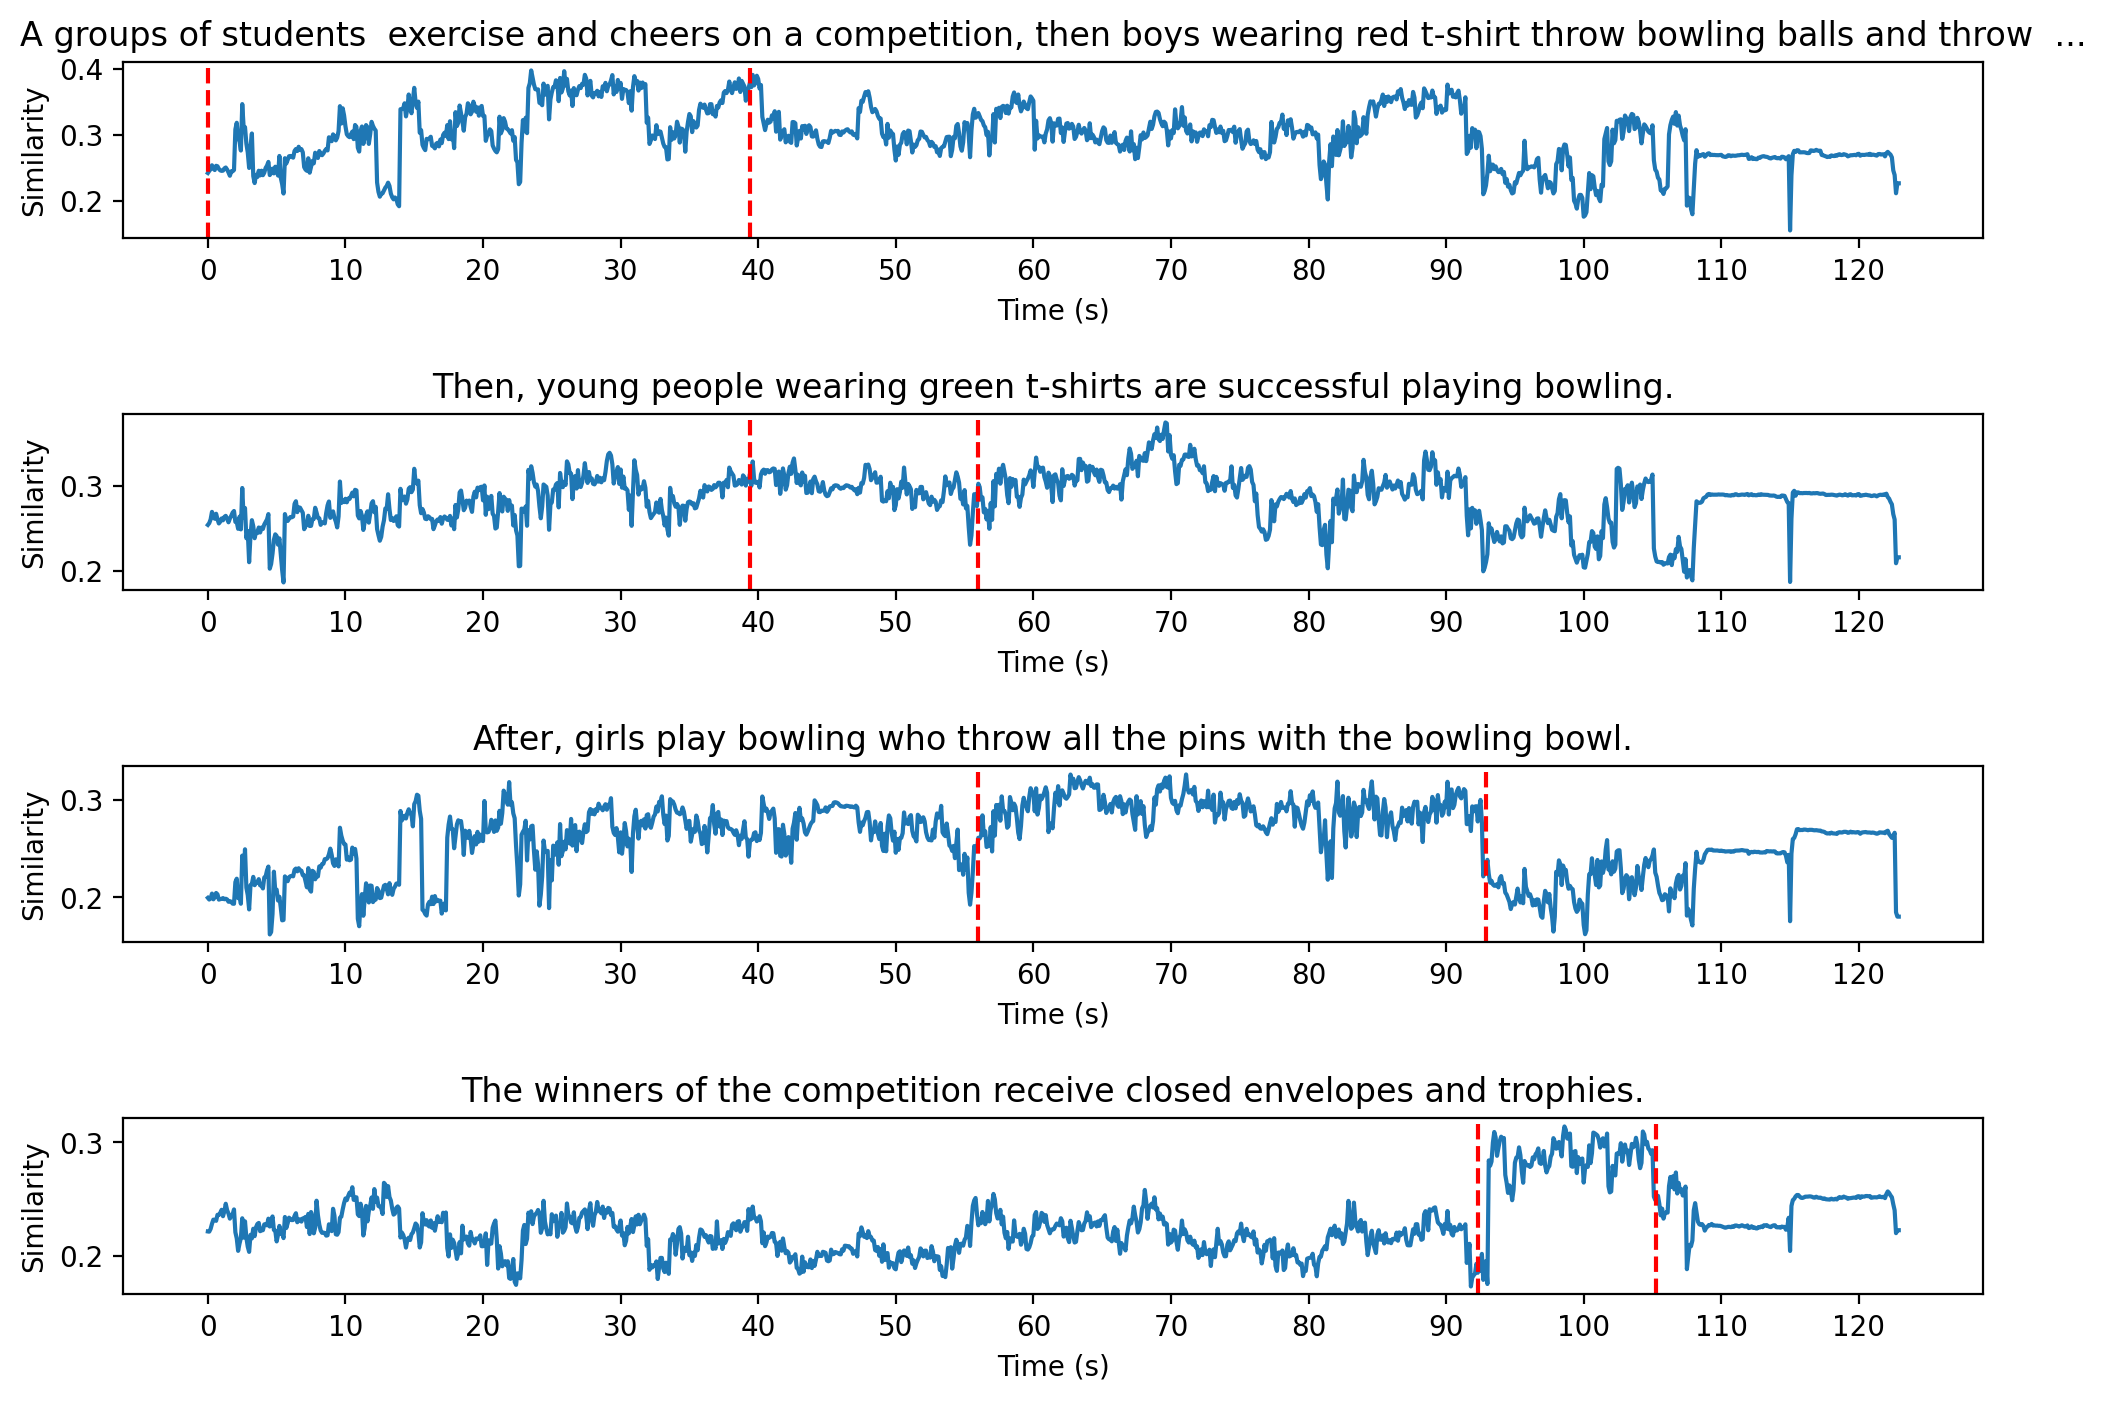

YIYZHQUOtnA-10fps-multiple.png

URL: https://www.youtube.com/watch?v=YIYZHQUOtnA


In [ ]:
random_sentences =None #["It's a video of a man vlogging in a bathroom, posing in front of a mirror and holding a camera. He kneels for a white cat carried by a woman. Later, they're seen driving, visiting a restaurant and playing while cleaning the car's windshield."]
framerate = 10

torch.cuda.empty_cache()

similarity_scores, video_id = video_analysis(data, length=100, random_sentences = random_sentences, framerate = framerate, video_id= 'v_YIYZHQUOtnA')

setting = {
           'force_separate_subplots' : True, #Disables all of the followings if be True
          #  'show_random_plots': True,
          #  'show_corresponding_label_plot' : True,
          #  'show_prompt_label_plot' : True,
          #  'show_concate_descriptions_plot': True,
          #  'show_average_plot':True,
           'show_max_plot': True,
           'show_min_plot': True,
          #  'show_each_plot': True,
           }

sentences, timestamps, duration, corresponding_label = load_video_informations(video_id)

# print_sentences(corresponding_label, sentences, random_sentences)
plot_list_of_lists(similarity_scores, sentences, random_sentences, timestamps, framerate=framerate, **setting)

print(f"{video_id[2:]}-{framerate}fps-{summarize_settings(setting)}.png")
print(f'\nURL: https://www.youtube.com/watch?v={video_id[2:]}')

In [ ]:
similarity_scores

<br><br><br><br><br><br><br><br><br>

In [ ]:
import json

def write_results_to_json(key_names, description, similarity_scores, timestamps, output_file, indent=2):
    # create a list of dictionaries for the descs section
    descs = []
    for i, key_name in enumerate(key_names):
        desc = {"name": key_name, "sentence": description[i]}
        if key_name.startswith("Description"):
            idx = int(key_name.split(" ")[1]) - 1
            desc["timestamp"] = timestamps[idx]
        descs.append(desc)

    # create a dictionary for the results section
    results = {}
    for i, key_name in enumerate(key_names):
        results[key_name] = similarity_scores[i].tolist()

    # create the final dictionary and write to a JSON file with indentation
    data = {"descs": descs, "results": results}
    with open(output_file, "w") as f:
        json.dump(data, f, indent=indent)

In [ ]:
key_names = ['concat','label','prompt']

for i in range(len(sentences)):
  key_names.append(f'Description {i+1}')

# for i in range(len(random_sentences)):
#   key_names.append(f'Random Description {i+1}')


descriptions = ['cancate of descriptions', corresponding_label, f"It's a video of {corresponding_label}."] + sentences
descriptions = descriptions + random_sentences if random_sentences else descriptions
output_file = '/content/output.json'

write_results_to_json(key_names, descriptions, similarity_scores,timestamps, output_file,indent=1)


## Test

In [ ]:
import torch as th
import numpy as np
from PIL import Image

colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255)]
color_names = ['red','green','blue','yellow','light blue']

images = []
for color in colors:
    image = Image.new('RGB', (224, 224), color)
    images.append(image)

In [ ]:
print(image)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F55E689F610>


In [ ]:
# from transformers import CLIPProcessor, CLIPModel
# model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device).eval()
# processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
# clear_output()

from transformers import BlipProcessor, BlipModel
model = BlipModel.from_pretrained("Salesforce/blip-image-captioning-base").to(device).eval()
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
clear_output()

In [ ]:
outputs[0], similarity[0]

(array([0.3150283 , 0.24786451, 0.24867758, 0.23842958, 0.24287465],
       dtype=float32),
 array([0.2992553 , 0.23549017, 0.23633216, 0.2265379 , 0.23077935],
       dtype=float32))

['red', 'green', 'blue', 'yellow', 'light blue']


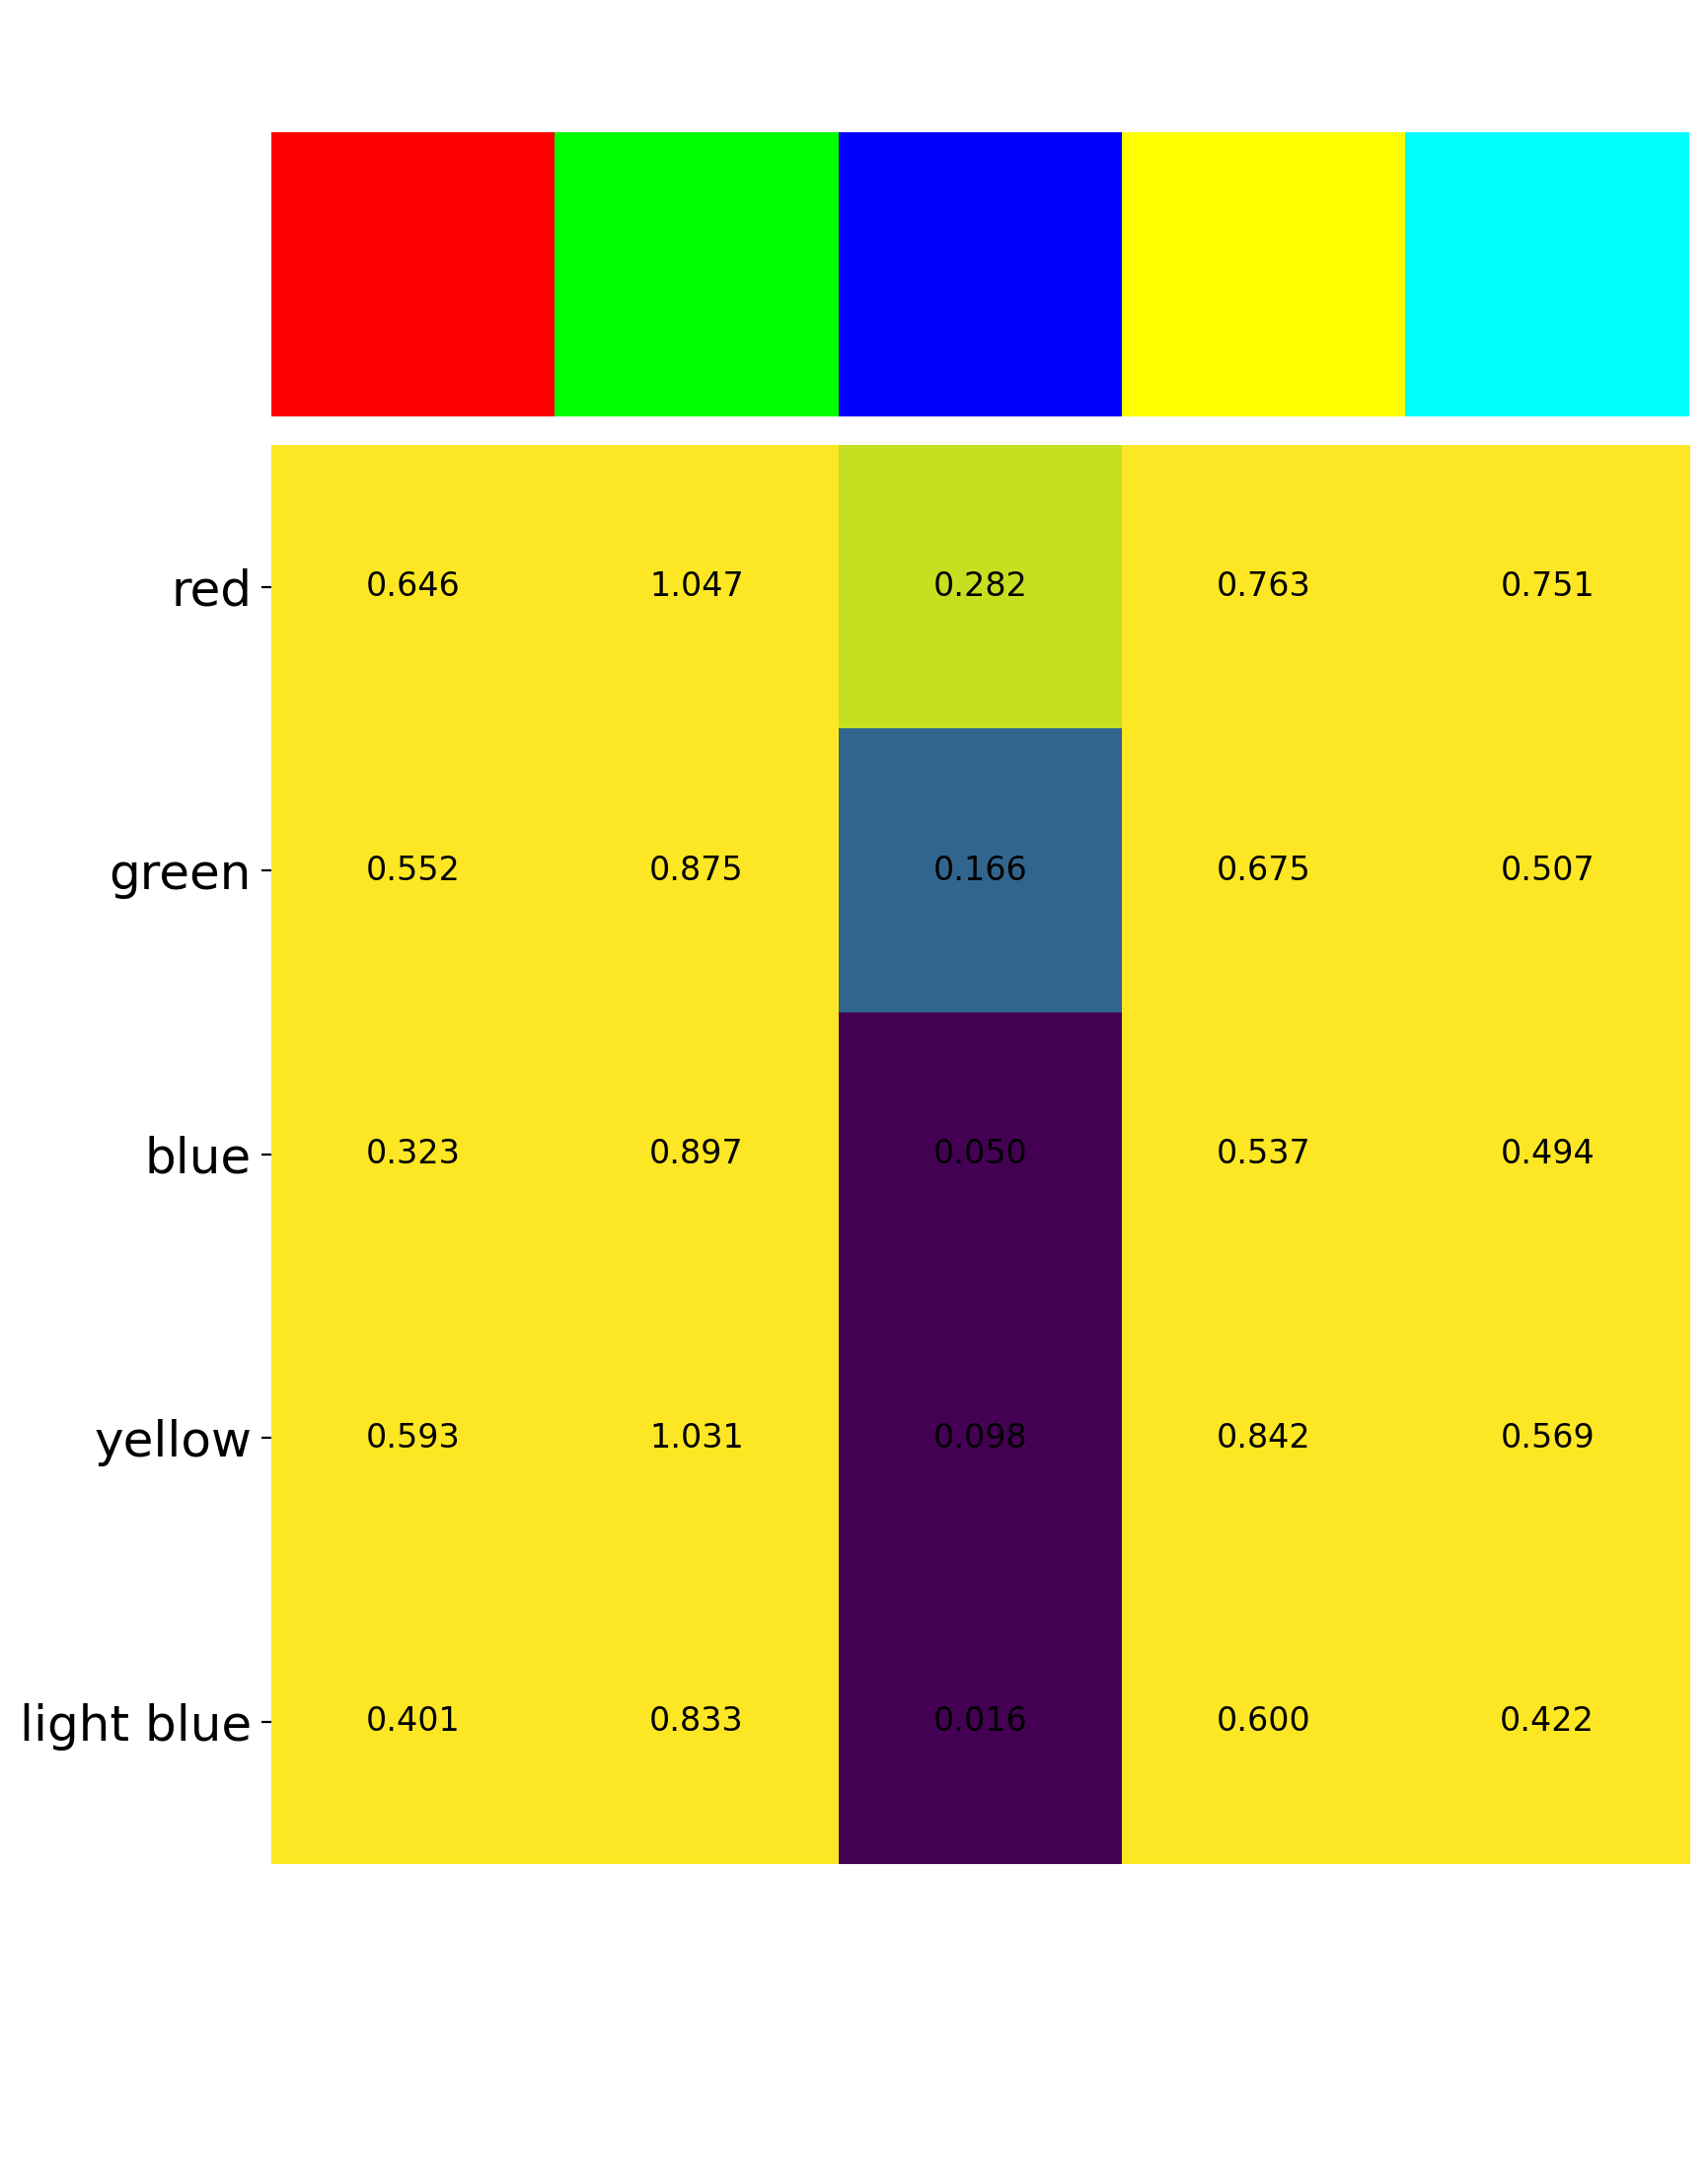

In [ ]:
sents = color_names #['Blue', 'Orange','Green', 'Red', 'purple', 'yellow']

inputs = processor(text=sents, images=images, return_tensors="pt", padding=True)

new_inputs = {}
for key in list(inputs.keys()):
    new_inputs[key] = inputs[key].to(device)

with torch.no_grad():
    outputs = model(**new_inputs)

outputs = outputs.logits_per_text.detach().cpu().numpy() * -1

count = len(sents)

plt.figure(figsize=(20, 14))
plt.imshow(outputs, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), sents, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(outputs.shape[1]):
    for y in range(outputs.shape[0]):
        plt.text(x, y, f"{outputs[y, x]:.3f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])


In [ ]:
image_features

tensor([[-0.0039, -0.0148, -0.0304,  ...,  0.0520, -0.0152,  0.0060],
        [-0.0078, -0.0256, -0.0168,  ...,  0.0615, -0.0137, -0.0079],
        [-0.0112, -0.0042, -0.0134,  ...,  0.0590, -0.0251, -0.0052],
        [ 0.0023, -0.0077, -0.0284,  ...,  0.0594,  0.0061,  0.0025],
        [-0.0084, -0.0131, -0.0284,  ...,  0.0553, -0.0226, -0.0047]],
       device='cuda:0')

In [ ]:
# ! pip install git+https://github.com/openai/CLIP.git 

from transformers import CLIPProcessor, CLIPModel
from PIL import Image
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device).eval()
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

#  -------------------

images = []
original_images = []
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255)]
color_names = ['red','green','blue','yellow','light blue']

for color in colors:
  image = Image.new('RGB', (224, 224), color)
  original_images.append(image)
  images.append(processor(images =image)['pixel_values'])

image_input = torch.squeeze(torch.tensor(np.stack(images)), dim=1).to(device)

with torch.no_grad():
    image_features = model.get_image_features(image_input).float()



image_features /= image_features.norm(dim=-1, keepdim=True)

sents = color_names #[f"It's an image of total {color}" for color in color_names]# ['Blue', 'Orange','Green', 'Red', 'yellow']]

# text_tokens = model.tokenize(sents).cuda()
with torch.no_grad():
    text_features = model.get_text_features(sents).float()
text_features /= text_features.norm(dim=-1, keepdim=True)

# ---------------------

similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

# ---------------------------

count = len(sents)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
plt.yticks(range(count), sents, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.3f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

# plt.title("Cosine similarity between text and image features", size=20)

AttributeError: ignored

In [ ]:
# ! pip install git+https://github.com/openai/CLIP.git 

from transformers import CLIPProcessor, CLIPModel
from PIL import Image
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device).eval()
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

#  -------------------

images = []
original_images = []
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255)]
color_names = ['red','green','blue','yellow','light blue']

for color in colors:
  image = Image.new('RGB', (224, 224), color)
  original_images.append(image)
  images.append(processor(images =image)['pixel_values'])

image_input = torch.squeeze(torch.tensor(np.stack(images)), dim=1).to(device)

with torch.no_grad():
    image_features = model.get_image_features(image_input).float()



image_features /= image_features.norm(dim=-1, keepdim=True)

sents = color_names #[f"It's an image of total {color}" for color in color_names]# ['Blue', 'Orange','Green', 'Red', 'yellow']]

# text_tokens = model.tokenize(sents).cuda()
with torch.no_grad():
    text_features = model.get_text_features(sents).float()
text_features /= text_features.norm(dim=-1, keepdim=True)

# ---------------------

similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

# ---------------------------

count = len(sents)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
plt.yticks(range(count), sents, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.3f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

# plt.title("Cosine similarity between text and image features", size=20)

AttributeError: ignored

In [ ]:
images

# Statistical analysis of the data 

In [ ]:
import math
def compute_size(tensor_shape):
    size = math.prod(tensor_shape) * 4 / 1024/1024

    if size/1024 <1:
      print(f"Size: {size:.2f} MB")
    else:
      print(f"Size: {size/1024:.2f} GB")

In [ ]:
compute_size((224,224,3,60*10,30))

Size: 10.09 GB


In [ ]:
data_path = f'datasets/ActivityNet/activity_net.v1-3.min.json'

with open(data_path) as f:
  data = json.load(f)

data = data["taxonomy"]

In [ ]:
def build_tree(nodes, parent_id=None):
    # Filter nodes with matching parent_id
    children = [node for node in nodes if node['parentId'] == parent_id]

    # Sort children by nodeName
    children.sort(key=lambda x: x['nodeName'])

    # Recursively build tree for each child
    tree = {}
    for child in children:
        tree[child['nodeName']] = build_tree(nodes, child['nodeId'])

    return tree

def print_tree(tree, level=0, indicators=['-','○','+','•']):
  # Iterate over tree
  for i, (name, child) in enumerate(tree.items()):
    # Select indicator based on level
    indicator = indicators[level % len(indicators)]

    # Print node with indicator and level
    print("  " * level + f"{indicator} {name}")

    # Recursively print child nodes
    if child:
        print_tree(child, level + 1, indicators)

In [ ]:
def get_min_max_time_segments(segments):
    start_times = [segment[0] for segment in segments]
    end_times = [segment[1] for segment in segments]
    min_start_time = min(start_times)
    max_end_time = max(end_times)
    return [min_start_time, max_end_time]

def get_total_length(segments):
    return sum([segment[1]-segment[0] for segment in segments])

def get_ratio(min_max_array,total_length):
    return (min_max_array[1]-min_max_array[0])/total_length